##### NOTE: Before using this notebook, you have to:
1.  **Downgrade** pandas version.

In [ ]:
!pip install --upgrade pandas==1.0.5

2. Mount google drive which contains resources

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Quotebank preprocessing

## 1. Coarse-grain preprocessing

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats import diagnostic 
import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
INPUT_PATH_PREFIX = '/content/drive/MyDrive/Quotebank/quotes-'
OUTPUT_PATH_PREFIX = '/content/drive/MyDrive/ADA_Resources/quotes'
FILE_EXTENSION = '.json.bz2'
POLITICIANS_PATH  = '/content/drive/MyDrive/ADA_Resources/speakers/us_politicians.json.bz2'

Since files containing quotes are too big, and they cannot fit in the RAM,
we will process them chunk by chunk. <br>
Coarse-grain preprocessing phase includes filtering empty quotes, dropping meaningless columns and perserving quotes if speaker is a politician (for more details, refer to notebook 'Wikidata_preprocessing.ipynb') <br>
In additon, processed chunks are merged, and if the size of merged data surpasses 1000000 quotes (size that can fit in the RAM), then merged data is written to a file.

In [13]:
# Load US politicians from pre-parsed parquet database
speakers = pd.read_json(POLITICIANS_PATH, lines= True, compression= 'bz2') 

In [ ]:
# Create set of qids
speaker_ids = set(speakers.id.values)

# Process years
for year in range(2015,2021):
  
  input_path  = INPUT_PATH_PREFIX + str(year) + FILE_EXTENSION

  # Create data chunks iterator
  data_chunks = pd.read_json(input_path, lines=True, 
                           compression='bz2', chunksize=100000)
  
  # Process data chunks
  MEANINGLESS_COLUMNS = ['phase', 'probas']

  # Create empty DataFrame for merging
  merged_data = pd.DataFrame([])
  i=0
  for chunk in data_chunks:

    # Create DataFrame 
    data = pd.DataFrame(chunk)

    # Filter data
    # Definitions of these functions are at the end of the notebook
    data = filter_politicians(data, speaker_ids)
    data = filter_empty_quotes(data)
    data = filter_by_phase(data)
    
    # Drop meaningless columns
    data = data.drop(columns=MEANINGLESS_COLUMNS)

    merged_data = pd.concat([merged_data, data])
    
    ''' 
    If size of merged_data surpasses 1000000 quotes, write it to file
    and clear merged_data DataFrame
    ''' 
    if merged_data.shape[0] > 1e6:
      i+=1
      output_path = OUTPUT_PATH_PREFIX + str(year) +
                    '_chunk_'+str(i) + OUTPUT_EXTENSION
      merged_data.to_json(output_path, compression='bz2', lines= True, orient='records')
      merged_data =  pd.DataFrame([])

NOTE: Execution of the above cell consumes enormous amount of time <br>
 

## 2. Fine-grain preprocessing
<a id='2'></a>

Note that the same preprocessing process is performed on all data, but in order not to overflood the notebook, only fine-grain preprocessing of the data from year 2020 will be shown. 

In [14]:
# Load data 
input_path = '/content/drive/MyDrive/ADA_Resources/Merged/quotes2020_merged_part_1' + FILE_EXTENSION
quotes2020 = pd.read_json(input_path, lines=True, 
                           compression='bz2')

- <h3> Preprocessing quotations with multiple qids </h3>
Now we will examine how many quotes exists which have multiple qids for their speakers.

In [15]:
quote_count_with_multiple_qids = (quotes2020.qids.str.len() > 1).sum()
print('There are %d quotes with multiple qids.' % quote_count_with_multiple_qids)
print('There are %.2lf%% quotes with multiple qids.' % (quote_count_with_multiple_qids*100 / quotes2020.shape[0]))

There are 121913 quotes with multiple qids.
There are 26.58% quotes with multiple qids.


For the year 2020, we can conclude that approximately 30% of the quotations do not have unique speaker's qid. <br>
Let us see how many quotations have more than one qids which correspond to a politician.

In [16]:
# Create set of qid of all politicians
speakers_id_set = set(speakers.id.values)

In [17]:
# Extracting number of politicians in qids array of each quote
def count_politicians(qids):
  '''
  Counts how many politicians are there in qids array.
  Arguments:
    qids: pd.Series
      Series of qids
  Returns: int
    Number of politicians in qids 
  '''
  return len(set(qids) & (speakers_id_set))

politicians_in_qids_count = quotes2020.qids.apply(count_politicians)
multiple_politicians_in_qids = (politicians_in_qids_count> 1).sum()
print('There are %d quotes which in qids array have more than 1 politician.' % 
      multiple_politicians_in_qids)

There are 18350 quotes which in qids array have more than 1 politician.


Since we cannot with certainty link these quotes (quotes with more than one qid) to the specific person, we decided to:
1. Discard all quotes which have more than one US politician in the qids array. <br>
Situation where single quote could be assigned to one of multiple politicians introduces enormous uncertainty. In addition, such quotes represent minority of the dataset, so this type of quotes will be discarded.


In [18]:
# Discarding quotes with multiple politicians in qids array
quotes2020 = quotes2020[politicians_in_qids_count == 1]

2. Perserve quotes which have only one US politician in qids array. <br>
After thorough analysis, we found out that there are too many quotes of this type. If we discard them, then we will discard too many valuable speakers from our dataset. If speaker is someone like Donald Trump, it is justified to assume that it is the president of the USA, and not the [physician](https://www.wikidata.org/wiki/Q27947481).<br>
Our decision will rely on a fact that politicians are more likely to be present in media.
Therefore, we will assume that the speaker is most likely a politician, and quote will be assigned to politician's qid. However, this assumption introduces uncertainty, and we will have to be aware of that while making decisions.

In [19]:
# Assigning quote to politician's qid from qids array
quotes2020['qids'] = quotes2020.qids.apply(lambda qids: (set(qids) & speakers_id_set).pop())
quotes2020.head(3)


,quoteID,quotation,speaker,qids,date,numOccurrences,urls
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,2020-01-16 12:00:13,1,[http://thehill.com/opinion/international/4782...
1,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,Q816459,2020-03-19 19:14:00,1,[https://mortgageorb.com/hud-fha-suspend-forec...
2,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,2020-01-26 13:21:36,11,[http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/...


- <h3> Preprocessing unconsistency in speaker's name </h3>
Let us take an example:  

In [20]:
# Extract speaker's whose name contains 'Trump'
quotes2020[quotes2020.speaker.str.contains('Trump')].head(2)

,quoteID,quotation,speaker,qids,date,numOccurrences,urls
19,2020-02-19-010736,But I happen to like Prime Minister (Narendra)...,Donald Trump,Q22686,2020-02-19 03:24:32,8,[https://www.orissapost.com/donald-trump-hints...
20,2020-02-07-012379,but [ President ] Trump (was) eager to make a ...,President Donald Trump,Q22686,2020-02-07 23:05:05,1,[http://uspolitics.einnews.com/article/5092030...


As we can see, there exist speakers with different names, but same qids. <br> In order to fix this unconsistency, we will replace speaker's name (column 'speaker') in the 'Quotebank' database with column 'label' from the 'us_politicians' database (i.e. speakers DataFrame). 

In [21]:
# Merge Quotebank 2020 and 'us_politicians' DataFrames
quotes2020 = pd.merge(right = quotes2020, right_on='qids',
          left=speakers[['id', 'label']], left_on='id')

# Drop redundant columns
quotes2020 = quotes2020.drop(columns=['speaker', 'id'])

# Rename columns in order to perserve consistency
quotes2020 = quotes2020.rename(columns={'label': 'speaker'})

- <h3> Removing duplicates </h3>
Now we will determine if there exist duplicates in column 'quoteID'.

In [22]:
# Extract number of duplicates
duplicates = quotes2020.quoteID.duplicated()
print('There are %d duplicates.' % duplicates.sum())

There are 29310 duplicates.


And now we will drop them.

In [23]:
# Drop duplicates
quotes2020 = quotes2020[~duplicates]

- <h3> Removing short quotations </h3>
We will observe length of quotes described in number of words. 

Text(0.5, 0, 'Length of quotation')

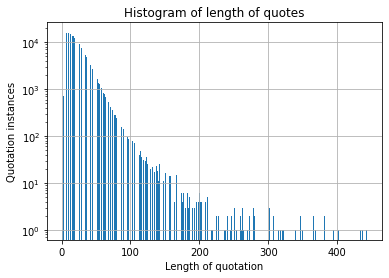

In [ ]:
# Extract number of words in each quote
quote_length = quotes2020.quotation.apply(lambda quote: len(quote.split()))

# Plot histogram
quote_length.hist(bins=1000, log=True)
plt.title('Histogram of length of quotes')
plt.ylabel('Quotation instances')
plt.xlabel('Length of quotation')


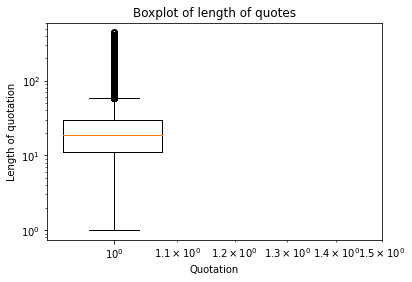

In [ ]:
# Boxplot of length of quotes
plt.boxplot(quote_length.values)
plt.title('Boxplot of length of quotes')
plt.xlabel('Quotation')
plt.ylabel('Length of quotation')
plt.loglog(True)

On the plot we can notice that there exist quotes containing a small number of words. Moreover, we will discard quotes consisting of less than 3 words, since they provide very little information.

In [ ]:
# Discarding quotes containing length less than 3 words
quotes2020 = quotes2020[quote_length > 2]

- <h3> Converting column 'date' to Date type  </h3>
Lastly, we will convert column 'date' to Date type.

In [ ]:
# Convert column to DateTime type
quotes2020.date = pd.to_datetime(quotes2020.date)

# Truncate hours, minutes and seconds
quotes2020.date = quotes2020.date.apply(lambda date: datetime.date(date.year, date.month, date.day))

## EXAMINING DATA

Now we will perform some descriptive analysis. <br>
As a representative, again, we will use preprocessed quotes from year 2020. 

### 1. Examining speakers and their occurrences  

Firstly, we will examine occurences of speakers, and try to infer 
from which underlying distribution the data comes from.

In [ ]:
# Extract number of occurences of given speaker
speaker_occurences = quotes2020.groupby('speaker').count().sort_values(by='quotation', ascending = False)[['quotation']]
speaker_occurences[:10]

,quotation
speaker,
Donald Trump,48544
Bernie Sanders,39912
Joe Biden,12937
Andrew Cuomo,11133
Elizabeth Warren,7672
Pete Buttigieg,6111
Michael Bloomberg,6041
Mike Pompeo,6000
Nancy Pelosi,5656


Text(0.5, 1.0, "Histogram of number of speaker's occurrences")

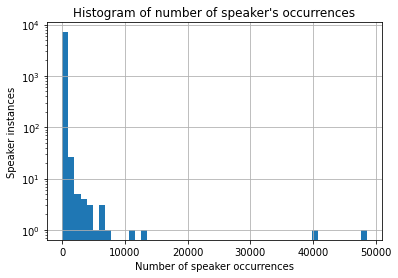

In [ ]:
speaker_occurences.quotation.hist(log = True, bins= 50)
plt.xlabel('Number of speaker occurrences')
plt.ylabel('Speaker instances')
plt.title('Histogram of number of speaker\'s occurrences')

It looks like random variable describing number of quotes said by specific speaker could follow exponential or heavy-tailed distribution. <br>
Let us test it:

In [ ]:
diagnostic.kstest_normal(speaker_occurences.quotation.values, dist = 'exp')

(0.4200622097748876, 0.01)

Since p-value is smaller than 0.05, we reject hypothesis that it comes from exponential dristribution. <br>
How about heavy-tailed?

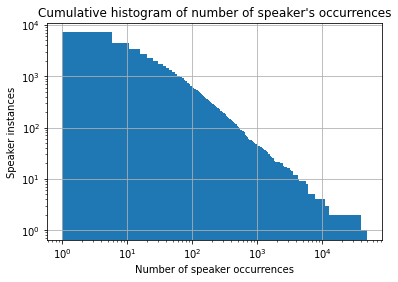

In [ ]:
speaker_occurences.quotation.hist(log=True, bins = 10000, cumulative= -1)
plt.xlabel('Number of speaker occurrences')
plt.ylabel('Speaker instances')
plt.title('Cumulative histogram of number of speaker\'s occurrences')
plt.loglog(True)

It looks like power-law distribution may actually be the underlying distribution. <br>Since we now believe that it is power-law distribution, we should be aware that some speakers are overrepresented in the data. Thus, we should be aware that data may be biased towards frequently quoted speakers. <br>
Let us use Donald Trump as an example. He is the most frequently quoted speaker, and he is a member of the Republican party. However, his attidute towards certain topics does not necessarily reflect the attitude of his party towards the same topic. But, the sheer number of his quotes gives rise to a correlation between his party's attitudes and his own, so we will have use more sophisticated methods (e.g. matching) in order to find causality.

### 2. Examining number of occurences of quotes  

Now we will try to infer underlying distribution of the random variable that describes number of occurences of specific topic in different media. <br>

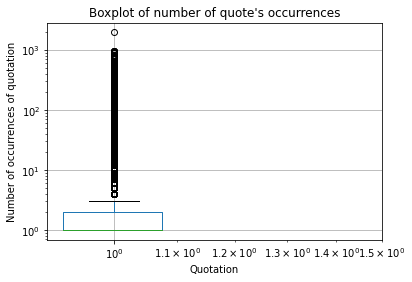

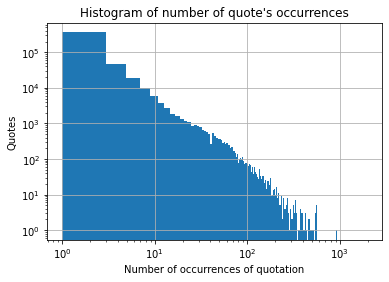

In [ ]:
# Boxplot of a column 'numOccurrences'
quotes2020.boxplot(column = 'numOccurrences')
plt.ylabel('Number of occurrences of quotation')
plt.xlabel('Quotation')
plt.title('Boxplot of number of quote\'s occurrences')
plt.loglog(True)

# Histogram of a column 'numOccurrences'
quotes2020.hist(column = 'numOccurrences', bins = 1000)
plt.ylabel('Quotes')
plt.xlabel('Number of occurrences of quotation')
plt.title('Histogram of number of quote\'s occurrences')
plt.loglog(True)

Presented plots show us that extreme values are rare, but not very rare.<br> It can be concluded that this random variable also follows heavy-tailed distribution, so metrics like mean and std are not credible in describing this attribute. This attribute can be used to describe level of impact that the quote had (i.e. if more sources have cited the quotation, then the quotation is more valuable).

### 3. Examining quotes by date
Finally, we will examine distribution of quotes in time sequence. Unit of time would be a day.

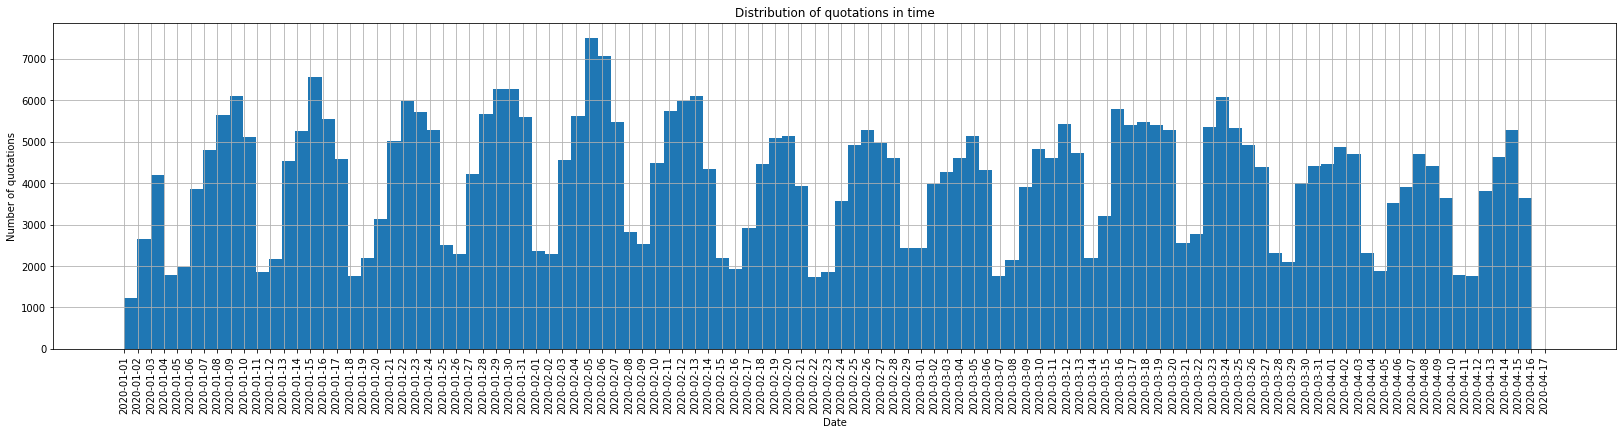

In [ ]:
# Extract every date in sorted order from 'date' column
date_ticks = quotes2020.date.sort_values().unique()

# Plot histogram
fig = plt.figure(figsize=(28,6))
quotes2020.date.hist(bins = date_ticks.shape[0])
plt.xticks(rotation=90 , ticks= date_ticks)
plt.ylabel('Number of quotations')
plt.title('Distribution of quotations in time')
plt.xlabel('Date')
plt.show()

From the plot above, we can observe periodicity on a weekly basis, with spikes on days with important events. For example, the spike on 16/01/2020 is the day the [impeachment trial](https://www.onthisday.com/date/2020/january/16) of US President Donald Trump began. <br> It would be interested to observe how much of a media awarness gained quotes relevant to our topic, despite the fact that different events on different dates got more attention.  

## HELPER FUNCTIONS

In [ ]:
def filter_politicians(data, speaker_ids):
  '''
  Filtering quotations by speakers. Perserving quotes whose speakers are
  politicians
  Arguments:
    data: pandas.DataFrame
      frame of quotes
    speaker_ids: set
      set of qids od politicians
  Returns:
    pandas.Dataframe
  '''
  data  = data[ data.speaker !='None']
  is_politician = data.qids.apply(lambda qids: len((set(qids)  & (speaker_ids)))>0)
  return data[is_politician]

In [ ]:
def filter_by_phase(data):
  '''
  Filtering quotation by phase. Perserving quotes extracted in phase E
  Arguments:
    data: pandas.DataFrame
      frame of quotes
  Returns:
    pandas.Dataframe
  '''
  return data[data.phase=='E']

In [ ]:
def filter_empty_quotes(data):
  '''
  Dropping empty quotes
  Arguments:
    data: pandas.DataFrame
      frame of quotes
  Returns:
    pandas.Dataframe
  '''
  data = data[~(data.quotation.str.len()==0)]
  data = data[data.quotation.notnull()]
  return data 